# 딥러닝을 사용한 추천 시스템

In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

In [2]:
# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [3]:
# train test 분리
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

### keras를 이용한 MF 신경망 구현

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# from tensorflow.keras.utils import plot_model

In [5]:
# Variable 초기화 
K = 200                             # Latent factor 수 (잠재요인 수)
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

In [6]:
# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [7]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # 사용자 embedding layer 지정 (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # 아이템 embedding layer 지정 (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

In [8]:
#R = Dot(axes=2)([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2)                      # 사용자, 아이템 내적 연산 (1, 1, 1)
#R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)                                                        # (1, 1)

In [9]:
# Model setting
model = Model(inputs=[user, item], outputs=R) # 입출력 정의 
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=60,
  batch_size=256,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

Train on 75000 samples, validate on 25000 samples
Epoch 1/60


C:\Users\user\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 2304/75000 [..............................] - ETA: 25s - loss: 5.5028 - RMSE: 1.1136 

C:\Users\user\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


75000/75000 [==============================] - 3s 36us/sample - loss: 5.2727 - RMSE: 1.1235 - val_loss: 5.0366 - val_RMSE: 1.1265
Epoch 2/60
75000/75000 [==============================] - 2s 24us/sample - loss: 4.8119 - RMSE: 1.1215 - val_loss: 4.6024 - val_RMSE: 1.1246
Epoch 3/60
75000/75000 [==============================] - 2s 24us/sample - loss: 4.4019 - RMSE: 1.1196 - val_loss: 4.2162 - val_RMSE: 1.1229
Epoch 4/60
75000/75000 [==============================] - 2s 25us/sample - loss: 4.0376 - RMSE: 1.1181 - val_loss: 3.8728 - val_RMSE: 1.1213
Epoch 5/60
75000/75000 [==============================] - 2s 26us/sample - loss: 3.7133 - RMSE: 1.1164 - val_loss: 3.5673 - val_RMSE: 1.1198
Epoch 6/60
75000/75000 [==============================] - 2s 26us/sample - loss: 3.4251 - RMSE: 1.1149 - val_loss: 3.2957 - val_RMSE: 1.1184
Epoch 7/60
75000/75000 [==============================] - 2s 30us/sample - loss: 3.1687 - RMSE: 1.1136 - val_loss: 3.0542 - val_RMSE: 1.1171
Epoch 8/60
75000/75000 [

Epoch 59/60
75000/75000 [==============================] - 2s 30us/sample - loss: 1.1132 - RMSE: 1.0955 - val_loss: 1.1174 - val_RMSE: 1.0997
Epoch 60/60
75000/75000 [==============================] - 2s 30us/sample - loss: 1.1126 - RMSE: 1.0953 - val_loss: 1.1169 - val_RMSE: 1.0997


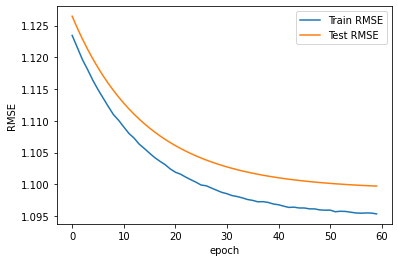

In [12]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [13]:
# Prediction
# 예측 대상(사용자-아이템)을 train set의 맨 처음 6개로 정한다 
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu # 예측치를 구한 후 전체 평균을 더한다.
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

Actuals: 
        user_id  movie_id  rating
56284      642      1049       3
77295      864      1101       4
32683      145       134       4
47298       94       286       4
16094      360        13       3
40705      315       121       2

Predictions: 
 [[3.5232866]
 [3.576909 ]
 [3.5721054]
 [3.5806026]
 [3.548705 ]
 [3.5302157]]


In [14]:
# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.1005080476754379